## Identifier-level analysis

In this notebook, we examine naturalness effects for each identifier present in a gold SQL query in the SNAILS dataset. 


```
Copyright 2024 Kyle Luoma

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

In [18]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
from collections import defaultdict
import src.util.load_consolidated_results as lcr

#### Configurations

In [19]:
config_dict = {
    'annotation_dir': './data/nl-to-sql_performance_annotations/',
    'models': [
        'gemini-1.5-pro-latest', 
        'Phind-CodeLlama-34B-v2',
        'gpt-4-0125-preview', 'gpt-3.5-turbo', 
        'code-bison-32k', 
        'code-llama-7b', 'code-llama-34b'],
    'model_label_filter': [
        # 'code-bison-32k', 
        'gemini-1.5-pro', 
        'Phind-CodeLlama-34B-v2',
        # 'code-llama-34b', 
        # 'code-llama-7b', 
        'gpt-3.5', 
        # 'gpt-4-turbo',
        'gpt-4o',
        'DINSQL',
        'CodeS'
    ],
    'database': 'all', #Database name or 'all'
    'native_only': False,
    'model_sort': {
        'gemini-1.5-pro': 50,
        'gpt-4o': 80,
        'gpt-4-0125-preview': 100,
        'gpt-4-turbo': 100,
        'DINSQL': 110,
        'gpt-3.5': 200,
        'Phind-CodeLlama-34B-v2': 250,
        'code-llama-7b': 400,
        'code-llama-34b': 300,
        'code-bison-32k': 500,
        'CodeS': 600
    },
}
td_dict = {True: 1, False: 0}
nat_cat_dict = {'NATIVE': 0, 'N1': 1, 'N2': 2, 'N3': 3}
nat_weights_dict = {'N1': 1, 'N2': 0.5, 'N3': 0.0}
# cat_label_dict = {'N1': 'Most', 'N2': 'Medium', 'N3': 'Least', 'NATIVE': 'Native', 'combined': 'Combined'}
cat_label_dict = {
    'N1': 'Regular', 
    'N2': 'Low', 
    'N3': 'Least', 
    'NATIVE': 'Native Schema', 
    'combined': 'Combined'
    }
model_markers = ['.', '+', '*', 'v', 'x', 'o']
sns.set_theme(style="whitegrid")

#### Data Loading

In [20]:
loader = lcr.ConsolidatedResultsLoader()
annotation_df = loader.get_joined_dataframes()
identifier_token_df = loader.load_identifier_token_analysis_files()
if config_dict["database"] != "all":
    db_to_use = config_dict["database"]
    identifier_token_df = identifier_token_df.query(f"source_database=='{db_to_use}'")
    annotation_df = annotation_df.query(f"database=='{db_to_use}'")
naturalness_lookup_df = pd.read_excel('./data/gold-data/identifier-scores-evaluated-5-9-2024.xlsx')
# set to uppder case
naturalness_lookup_df['IDENTIFIER'] = naturalness_lookup_df['IDENTIFIER'].apply(lambda x: x.upper())
naturalness_lookup_df.set_index('IDENTIFIER', inplace=True)


ASIS_20161108_HerpInv_Database-N1-N1-code-bison-32k-evaluation-05-10-2024.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-code-llama-34b-evaluation-10-23-2023.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-code-llama-7b-evaluation-10-20-2023.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-CodeS-evaluation-10-08-2024.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-DINSQL-evaluation-09-26-2024.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-gemini-1.5-pro-latest-evaluation-05-10-2024.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-gpt-3.5-turbo-evaluation-05-09-2024.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-gpt-4-0125-preview-evaluation-05-09-2024.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-gpt-4o-evaluation-09-26-2024.xlsx
ASIS_20161108_HerpInv_Database-N1-N1-Phind-CodeLlama-34B-v2-evaluation-05-24-2024.xlsx
ASIS_20161108_HerpInv_Database-N2-N2-code-bison-32k-evaluation-05-10-2024.xlsx
ASIS_20161108_HerpInv_Database-N2-N2-code-llama-34b-evaluation-10-23-2023.xlsx
ASIS_20161108_HerpInv_Database-N2-N2-code-llama-7b-evaluatio

### Identifier-Level EDA

##### Make identifier presence, missing, and extra dictionaries 

this will allow us to measure identifier-level linking scores and see what (if any) relationships exist between identifier naturalness and their propensity for linking errors (missing or extra).

In [21]:
annotation_df = annotation_df[annotation_df.model.isin(config_dict["model_label_filter"])]
for x in annotation_df.model.unique():
    print(x)

CodeS
DINSQL
gemini-1.5-pro
gpt-3.5
gpt-4o
Phind-CodeLlama-34B-v2


In [22]:
annotation_df["model_abbreviated"] = annotation_df.model.apply(
    lambda x: {
        'code-bison-32k': 'Bsn-ZS', 
        'gemini-1.5-pro': 'Gem-1.5-ZS', 
        'Phind-CodeLlama-34B-v2': 'Ph-CdLlm2-ZS',
        'code-llama-34b': 'CdLlm2-34b-ZS', 
        'code-llama-7b': 'CdLlm2-7b-ZS', 
        'gpt-3.5': 'GPT-3.5-ZS', 
        'gpt-4-turbo': 'GPT-4T-ZS',
        'gpt-4o': 'GPT-4o-ZS',
        'DINSQL': 'DINSQL',
        'CodeS': 'CodeS'
    }[x])

annotation_df["model_prompt"] = annotation_df.model.apply(
    lambda x: {
        'code-bison-32k': 'Bison-ZS', 
        'gemini-1.5-pro': 'Gemini-1.5-ZS', 
        'Phind-CodeLlama-34B-v2': 'Phind-CodeLlama2-ZS',
        'code-llama-34b': 'CodeLlama2-34b-ZS', 
        'code-llama-7b': 'CodeLlama2-7b-ZS', 
        'gpt-3.5': 'GPT-3.5-ZS', 
        'gpt-4-turbo': 'GPT-4T-ZS',
        'gpt-4o': 'GPT-4o-ZS',
        'DINSQL': 'GPT-4o-DINSQL',
        'CodeS': 'Codes-FT'
    }[x])

In [23]:
def default_int():
    return 0

all_model_dfs = []

for model in annotation_df.model.unique():
    # json.loads(annotation_df.iloc[0]['matching_tables'])
    identifier_presense_dict = defaultdict(default_int)
    identifier_missing_dict = defaultdict(default_int)
    identifier_extra_dict = defaultdict(default_int)
    remove = ['{', '}', "'"]
    # Extract the identifiers from the annotation dataframe and store them in a dictionary along with their frequencies
    for row in annotation_df.query(f"naturalness=='NATIVE' and model=='{model}'").itertuples():
        temp_stat_dict = {}
        temp_stat_dict['matching_tables'] = row.matching_tables
        temp_stat_dict['matching_columns'] = row.matching_columns
        temp_stat_dict['missing_tables'] = row.missing_tables
        temp_stat_dict['missing_columns'] = row.missing_columns
        temp_stat_dict['extra_tables'] = row.extra_tables
        temp_stat_dict['extra_columns'] = row.extra_columns
        for key in temp_stat_dict.keys():
            for c in remove:
                temp_stat_dict[key] = temp_stat_dict[key].replace(c, '')
            temp_stat_dict[key] = temp_stat_dict[key].split(',')
            for identifier in temp_stat_dict[key]:
                identifier = identifier.strip()
                if 'matching' in key:
                    identifier_presense_dict[identifier] += 1
                elif 'missing' in key:
                    identifier_missing_dict[identifier] += 1
                elif 'extra' in key:
                    identifier_extra_dict[identifier] += 1
    print(identifier_presense_dict)
    print(identifier_missing_dict)
    print(identifier_extra_dict)
    # Make a list of all the identifiers
    full_identifier_list = list(identifier_presense_dict.keys()) + list(identifier_missing_dict.keys())

    full_identifier_list = [i for i in full_identifier_list if i != 'set()']
    full_identifier_list = [i for i in full_identifier_list if i in naturalness_lookup_df.index]

    ident_linking_scores = {
        'identifier': full_identifier_list,
        'model': [],
        'matches': [],
        'missing': [],
        'extra': [],
        'naturalness': [],
        'recall': [],
        'precision': [],
        'f1': []
    }

    for ident in ident_linking_scores['identifier']:
        #calculate recall, precision, and f1. Handle divide by zero errors
        ident_linking_scores['model'].append(model)
        ident_linking_scores['naturalness'].append(
            naturalness_lookup_df.loc[ident]['SCORE']
            )
        
        ident_linking_scores['matches'].append(identifier_presense_dict[ident])
        ident_linking_scores['missing'].append(identifier_missing_dict[ident])
        ident_linking_scores['extra'].append(identifier_extra_dict[ident])
        
        # recall is the number of true positives divided by the number of true positives plus false negatives
        if identifier_presense_dict[ident] + identifier_missing_dict[ident] == 0:
            recall = 0
        else:
            recall =  identifier_presense_dict[ident] / (identifier_presense_dict[ident] +  identifier_missing_dict[ident])
        ident_linking_scores['recall'].append(recall)

        # precision is the number of true positives divided by the number of true positives plus false positives
        if identifier_presense_dict[ident] == 0 and identifier_extra_dict[ident] == 0:
            precision = 0
        else:
            precision = identifier_presense_dict[ident] / (identifier_presense_dict[ident] + identifier_extra_dict[ident])
        ident_linking_scores['precision'].append(precision)

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        ident_linking_scores['f1'].append(f1)

    all_model_dfs.append(pd.DataFrame(ident_linking_scores))

ident_linking_scores_df = pd.concat(all_model_dfs)
ident_linking_scores_df['naturalness_label'] = ident_linking_scores_df['naturalness'].apply(lambda x: cat_label_dict[x])
ident_linking_scores_df['naturalness_num'] = ident_linking_scores_df['naturalness'].apply(lambda x: nat_weights_dict[x])
ident_linking_scores_df['has_whitespace'] = ident_linking_scores_df.identifier.apply(
    lambda x: " " in x.strip()
)


defaultdict(<function default_int at 0x000002177A692020>, {'TBLFIELDDATATURTLEMEASUREMENTS': 10, 'AGE': 3, 'LOCATIONID': 12, 'WEIGHT': 5, 'TBLFIELDDATASNAKEDATACOLLECTION': 6, 'TBLFIELDDATAMINNOWTRAPSURVEYS': 5, 'COUNT': 3, 'STAGE': 2, 'TBLFIELDDATAAMPHIBIANCALLCOUNTS': 1, 'TBLFIELDDATAWATERPROPERTIES': 2, 'TEMPC': 2, 'CONDUCTIVITY': 1, 'PH': 1, 'SALINITY': 1, 'TBLFIELDDATATURTLETRAPSURVEYS': 3, 'RECORDID': 2, 'COMMENTS': 2, 'SEX': 5, 'SVL': 2, 'TLENGTH': 1, 'SPECIES_CODE': 3, 'OBSERVER_LU': 4, 'OBSINITS': 5, 'TLINKOBSERVERS': 3, 'LASTNAME': 11, 'EVENTID': 3, 'FIRSTNAME': 6, 'TBLFIELDDATAGREENCARDOBSERVATIONS': 1, 'TBLLOCATIONSPOINTS': 2, 'TBLFIELDDATATIMECONSTRAINEDSEARCHES': 1, 'UTMY': 2, 'UTMX': 2, 'DESCRIPTION': 3, 'TBLABUNDANCE_LU': 1, 'ABUNDANCE': 1, 'ABUNDANCEID': 1, 'TBLFIELDDATACOVERBOARD': 4, 'TYPE': 5, 'BOARD_#': 2, 'TBLEVENTDATAHERPS': 4, 'WEATHER': 3, 'AIRTEMP': 4, 'CAPTUREMETHOD': 2, 'BEHAVIOR': 2, 'NOTES': 3, 'POINTID': 1, 'SNAKEID': 1, 'WATERTEMP': 1, 'TLUPROJECT': 1, '

Join the identifier linking scores to token data

In [24]:
identifier_token_df['native_upper'] = identifier_token_df['native_identifier'].apply(lambda x: x.upper())
native_columns = [col for col in identifier_token_df.columns if 'native' in col]
native_columns.append("source_database")
identifiers_and_tokens_df = ident_linking_scores_df.set_index('identifier').join(
    identifier_token_df[native_columns + ['model']].set_index('native_upper'),
    how='left',
    lsuffix='_linking',
    rsuffix='_token'
    )

In [25]:
ident_linking_scores_df['model_sort'] = ident_linking_scores_df['model'].apply(lambda x: config_dict['model_sort'][x])
melted_ident_scores = ident_linking_scores_df.sort_values(by=['model_sort', 'naturalness']).melt(
    id_vars=['identifier', 'naturalness_label', 'model', 'has_whitespace'],
    value_vars=['recall'],
    var_name='metric',
    value_name='Recall'
)

In [26]:
melted_ident_scores["model_abbreviated"] = melted_ident_scores.model.apply(
    lambda x: {
        'code-bison-32k': 'Bsn-ZS', 
        'gemini-1.5-pro': 'Gem-1.5-ZS', 
        'Phind-CodeLlama-34B-v2': 'Ph-CdLlm2-ZS',
        'code-llama-34b': 'CdLlm2-34b-ZS', 
        'code-llama-7b': 'CdLlm2-7b-ZS', 
        'gpt-3.5': 'GPT-3.5-ZS', 
        'gpt-4-turbo': 'GPT-4T-ZS',
        'gpt-4o': 'GPT-4o-ZS',
        'DINSQL': 'DINSQL',
        'CodeS': 'CodeS'
    }[x])

##### Identifier naturalness x linking score metrics

$I_{match}$ -> The count of instances where an identifier is correctly present in all predicted queries. True positives.

$I_{missing}$ -> Count of instances where an identifier was present in the gold query but not the predicted query. False negatives.

$I_{extra}$ -> Count of instances where an identifier was present in a predicted query but not the gold query. False positives.

$Precision = \frac{I_{match}} {I_{match} + I_{extra}}$

$Recall = \frac{I_{match}} {I_{match} + I_{missing}}$

$F1 = 2 * \frac{Precision * Recall} {Precision + Recall}$

C:\Users\kyle.luoma\AppData\Local\Temp\ipykernel_42364\3699534093.py:1: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  g = sns.catplot(
C:\Users\kyle.luoma\AppData\Local\Temp\ipykernel_42364\3699534093.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
C:\Users\kyle.luoma\AppData\Local\Temp\ipykernel_42364\3699534093.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)


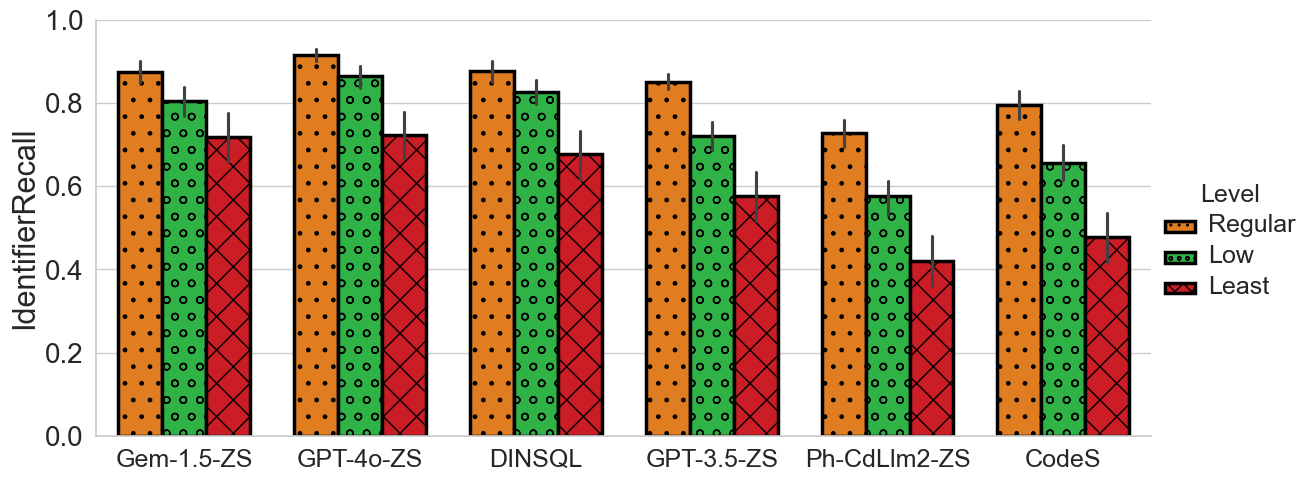

In [27]:
g = sns.catplot(
    data=melted_ident_scores,#.query("has_whitespace==False"),
    kind='bar',
    x='model_abbreviated',
    y='Recall',
    palette=sns.color_palette("bright")[1:],
    edgecolor="black",
    linewidth=2.5,
    aspect=2.3,
    width=.75,
    errorbar=('ci', 95),
    hue='naturalness_label',
    legend=True,
    )
g.set_axis_labels('', 'IdentifierRecall', size=20)
hatches = ['.', 'o', 'x']

for ax in g.axes.flat:
    ax.tick_params(labelsize=18)
    ax.set_xlabel(ax.get_xlabel(), fontsize=22)
    ax.set_ylabel(ax.get_ylabel(), fontsize=22)
    ax.set_title(ax.get_title(), fontsize=22)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

for j, f in enumerate(g.axes.flat):
    for i, thisbar in enumerate(f.patches):
        if i < 6:
            thisbar.set_hatch(hatches[0])
        elif i < 12:
            thisbar.set_hatch(hatches[1])
        elif i < 18:
            thisbar.set_hatch(hatches[2])
        # else:
        #     thisbar.set_hatch(hatches[3])
# g.add_legend(fontsize=24)
# set y axis to start at 0 and end at 1
g.set(ylim=(0, 1))
g.set_xticklabels(size=18)
g.set_yticklabels(size=20)
g.legend.set_title('Level', prop={'size': 18})
for t, l in zip(g._legend.texts, ['Regular', 'Low', 'Least']):
    t.set_text(l)
    t.set_fontsize(18)
hatches = ['..', 'oo', 'xx']
for legend_entry, hatch in zip(g.legend.get_patches(), hatches):
    legend_entry.set_hatch(hatch)
g.fig.savefig('./figure_output/identifier-recall.pdf', dpi=300, bbox_inches='tight')
